# Notebook for exploring the Playlists Dataset
Andrew Koulogeorge

In [1]:
import pandas as pd
import numpy as np
import glob
import json

In [2]:
NUM_FILES_TO_READ = 10

# Containers for our three DataFrames
playlist_song_records = []   # For DF1: each row maps a pid to a track_uri
track_records = {}           # For DF2: key = track_uri, value = track metadata
playlist_records = []        # For DF3: playlist-level metadata

# Use glob to get the JSON files and sort them.
# Adjust the path if your files are in a different directory.
file_pattern = "spotify_train_set/data/mpd.slice.*.json"
files = sorted(glob.glob(file_pattern))[:NUM_FILES_TO_READ]  # Process only the first 10 files

for file in files:
    with open(file, 'r', encoding='utf-8') as f:
        data = json.load(f)
        
        # Each file has an "info" field and a "playlists" field.
        playlists = data.get("playlists", [])
        
        for playlist in playlists:
            pid = playlist.get("pid")
            
            # Record playlist-level metadata (DF3)
            playlist_record = {
                "pid": pid,
                "playlist_name": playlist.get("name"),
                "description": playlist.get("description"),  # may be None if not provided
                "modified_at": playlist.get("modified_at"),
                "num_artists": playlist.get("num_artists"),
                "num_albums": playlist.get("num_albums"),
                "num_tracks": playlist.get("num_tracks"),
                "num_followers": playlist.get("num_followers"),
                "num_edits": playlist.get("num_edits"),
                "duration_ms": playlist.get("duration_ms"),
                "collaborative": playlist.get("collaborative")
            }
            playlist_records.append(playlist_record)
            
            # Process each track in the playlist (DF1 and DF2)
            tracks = playlist.get("tracks", [])
            for track in tracks:
                track_uri = track.get("track_uri")
                
                # DF1: Map pid to track_uri (include position if needed)
                playlist_song_records.append({
                    "pid": pid,
                    "track_uri": track_uri,
                    "pos": track.get("pos")
                })
                
                # DF2: Record track metadata only once per unique track_uri
                if track_uri not in track_records:
                    track_records[track_uri] = {
                        "track_uri": track_uri,
                        "track_name": track.get("track_name"),
                        "artist_name": track.get("artist_name"),
                        "artist_uri": track.get("artist_uri"),
                        "album_name": track.get("album_name"),
                        "album_uri": track.get("album_uri"),
                        "duration_ms": track.get("duration_ms")
                    }

# Create the DataFrames

# DF1: pid -> track_uri mapping
df_playlist_song = pd.DataFrame(playlist_song_records)

# DF2: track_uri -> track metadata
df_tracks = pd.DataFrame(list(track_records.values()))

# DF3: pid -> playlist metadata
df_playlists = pd.DataFrame(playlist_records)

In [3]:
print("Playlist-Song Mapping (DF1):")
print(df_playlist_song.head())

Playlist-Song Mapping (DF1):
   pid                             track_uri  pos
0    0  spotify:track:0UaMYEvWZi0ZqiDOoHU3YI    0
1    0  spotify:track:6I9VzXrHxO9rA9A5euc8Ak    1
2    0  spotify:track:0WqIKmW4BTrj3eJFmnCKMv    2
3    0  spotify:track:1AWQoqb9bSvzTjaLralEkT    3
4    0  spotify:track:1lzr43nnXAijIGYnCT8M8H    4


In [4]:
print("\nTrack Metadata (DF2):")
print(df_tracks.head())


Track Metadata (DF2):
                              track_uri  \
0  spotify:track:0UaMYEvWZi0ZqiDOoHU3YI   
1  spotify:track:6I9VzXrHxO9rA9A5euc8Ak   
2  spotify:track:0WqIKmW4BTrj3eJFmnCKMv   
3  spotify:track:1AWQoqb9bSvzTjaLralEkT   
4  spotify:track:1lzr43nnXAijIGYnCT8M8H   

                                   track_name        artist_name  \
0  Lose Control (feat. Ciara & Fat Man Scoop)      Missy Elliott   
1                                       Toxic     Britney Spears   
2                               Crazy In Love            Beyoncé   
3                              Rock Your Body  Justin Timberlake   
4                                It Wasn't Me             Shaggy   

                              artist_uri  \
0  spotify:artist:2wIVse2owClT7go1WT98tk   
1  spotify:artist:26dSoYclwsYLMAKD3tpOr4   
2  spotify:artist:6vWDO969PvNqNYHIOW5v0m   
3  spotify:artist:31TPClRtHm23RisEBtV3X7   
4  spotify:artist:5EvFsr3kj42KNv97ZEnqij   

                                     album_n

In [5]:
print("\nPlaylist Metadata (DF3):")
print(df_playlists.head())


Playlist Metadata (DF3):
   pid     playlist_name description  modified_at  num_artists  num_albums  \
0    0        Throwbacks        None   1493424000           37          47   
1    1  Awesome Playlist        None   1506556800           21          23   
2    2           korean         None   1505692800           31          51   
3    3               mat        None   1501027200           86         107   
4    4               90s        None   1401667200           16          16   

   num_tracks  num_followers  num_edits  duration_ms collaborative  
0          52              1          6     11532414         false  
1          39              1          5     11656470         false  
2          64              1         18     14039958         false  
3         126              1          4     28926058         false  
4          17              2          7      4335282         false  


# Visualization: create a histogram of artist, song and album information

In [6]:
# merge together dataframe from playlist -> song with song -> info
merged_df = pd.merge(df_playlist_song, df_tracks, on='track_uri', how='left')

# Check the first few rows to confirm that the merge worked
print(merged_df.head())


   pid                             track_uri  pos  \
0    0  spotify:track:0UaMYEvWZi0ZqiDOoHU3YI    0   
1    0  spotify:track:6I9VzXrHxO9rA9A5euc8Ak    1   
2    0  spotify:track:0WqIKmW4BTrj3eJFmnCKMv    2   
3    0  spotify:track:1AWQoqb9bSvzTjaLralEkT    3   
4    0  spotify:track:1lzr43nnXAijIGYnCT8M8H    4   

                                   track_name        artist_name  \
0  Lose Control (feat. Ciara & Fat Man Scoop)      Missy Elliott   
1                                       Toxic     Britney Spears   
2                               Crazy In Love            Beyoncé   
3                              Rock Your Body  Justin Timberlake   
4                                It Wasn't Me             Shaggy   

                              artist_uri  \
0  spotify:artist:2wIVse2owClT7go1WT98tk   
1  spotify:artist:26dSoYclwsYLMAKD3tpOr4   
2  spotify:artist:6vWDO969PvNqNYHIOW5v0m   
3  spotify:artist:31TPClRtHm23RisEBtV3X7   
4  spotify:artist:5EvFsr3kj42KNv97ZEnqij   

       

In [7]:
merged_df.shape

(670568, 9)

In [8]:
merged_df.columns

Index(['pid', 'track_uri', 'pos', 'track_name', 'artist_name', 'artist_uri',
       'album_name', 'album_uri', 'duration_ms'],
      dtype='object')

In [9]:
merged_df["track_uri"].nunique()

169657

In [10]:
merged_df['album_name'].head(10)

0                                    The Cookbook
1                                     In The Zone
2    Dangerously In Love (Alben für die Ewigkeit)
3                                       Justified
4                                        Hot Shot
5                                     Confessions
6                                     Confessions
7                                             PCD
8                       The Writing's On The Wall
9                     Speakerboxxx/The Love Below
Name: album_name, dtype: object

In [11]:
# get all the albumn names
album_counts = merged_df['album_name'].value_counts()
album_counts.head(10)


album_name
Views                        2178
Greatest Hits                1631
Stoney                       1569
More Life                    1552
DAMN.                        1405
Coloring Book                1405
Beauty Behind The Madness    1318
American Teen                1282
Culture                      1243
The Life Of Pablo            1172
Name: count, dtype: int64

In [12]:
artists_counts = merged_df['artist_name'].value_counts()
artists_counts.head(10)

artist_name
Drake             9071
Kanye West        4327
Kendrick Lamar    3459
Rihanna           3408
The Weeknd        3120
Eminem            3081
Future            2712
Ed Sheeran        2531
J. Cole           2470
Beyoncé           2419
Name: count, dtype: int64

In [13]:
track_counts = merged_df['track_name'].value_counts()
track_counts.head(10)

track_name
Closer                         696
Home                           523
One Dance                      467
Roses                          462
HUMBLE.                        458
Congratulations                429
Broccoli (feat. Lil Yachty)    423
Forever                        422
Ride                           416
Caroline                       393
Name: count, dtype: int64

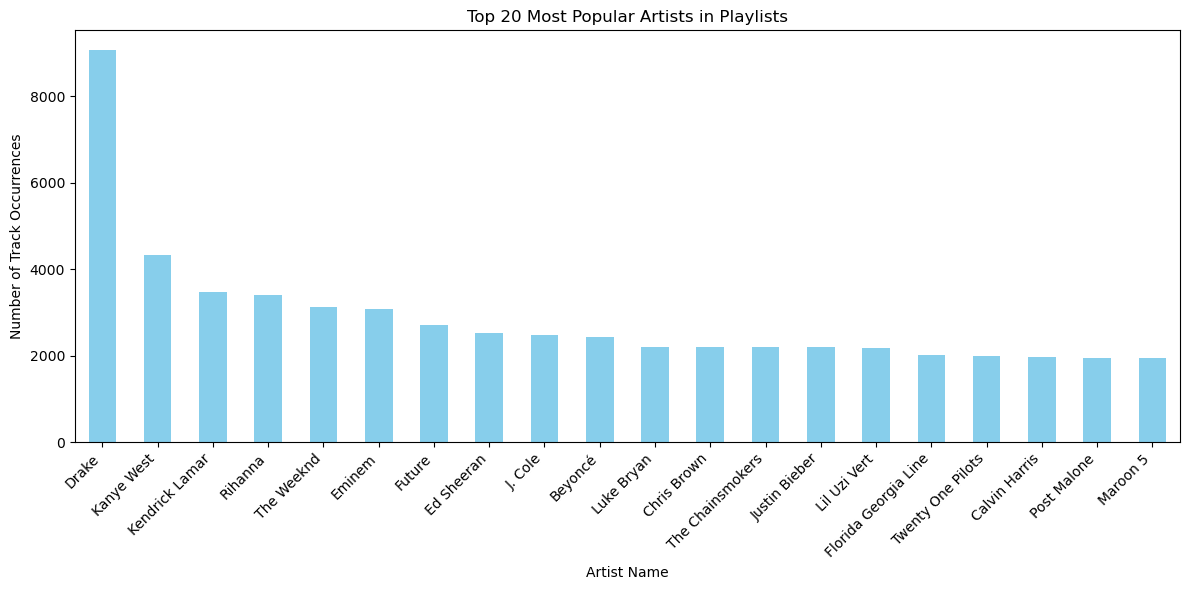

In [26]:
import matplotlib.pyplot as plt

# Set up the figure size
plt.figure(figsize=(12, 6))

# Plot a bar chart of the top 20 artists
artists_counts.head(20).plot(kind='bar', color='skyblue')

plt.title("Top 20 Most Popular Artists in Playlists")
plt.xlabel("Artist Name")
plt.ylabel("Number of Track Occurrences")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()


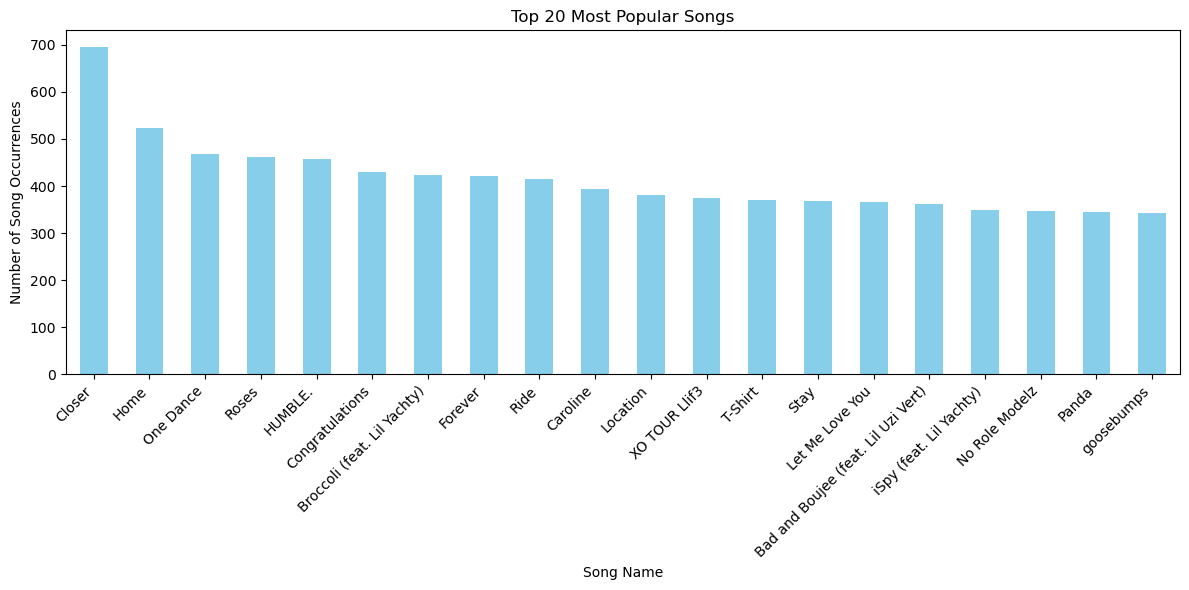

In [15]:
import matplotlib.pyplot as plt

# Set up the figure size
plt.figure(figsize=(12, 6))

# Plot a bar chart of the top 20 artists
track_counts.head(20).plot(kind='bar', color='skyblue')

plt.title("Top 20 Most Popular Songs")
plt.xlabel("Song Name")
plt.ylabel("Number of Song Occurrences")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

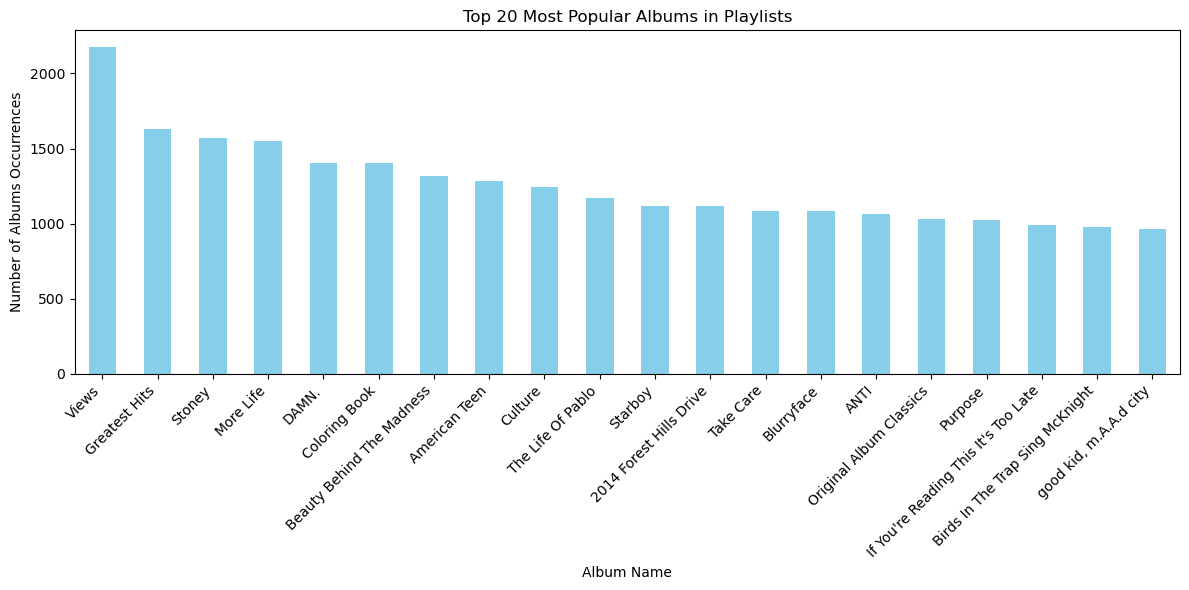

In [16]:
import matplotlib.pyplot as plt

# Set up the figure size
plt.figure(figsize=(12, 6))

# Plot a bar chart of the top 20 artists
album_counts.head(20).plot(kind='bar', color='skyblue')

plt.title("Top 20 Most Popular Albums in Playlists")
plt.xlabel("Album Name")
plt.ylabel("Number of Albums Occurrences")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()


In [17]:
# what artists occur the most together in a playlist? 

# define a map from (artistx, artisty) -> number of playlists they occured in together 
import itertools
from collections import Counter

# Assume merged_df is your DataFrame containing at least these columns:
# 'pid' (playlist ID) and 'artist_name' (the artist of each track)

# Create a Counter to hold the pair counts
artist_pair_counts = Counter()

# Group the merged DataFrame by playlist id
for pid, group in merged_df.groupby("pid"):
    artists = set(group["artist_name"].dropna().unique()) # Get the unique artists in this playlist (drop any missing values)
    
    # Only consider playlists with at least 2 unique artists
    if len(artists) > 1:
        # Generate all unordered pairs (sorted so that (A, B) == (B, A))
        for pair in itertools.combinations(sorted(artists), 2):
            artist_pair_counts[pair] += 1


In [18]:
# For example, print the top 10 most common artist pairs
top_10_pairs = artist_pair_counts.most_common(10)
print("Top 10 artist pairs by number of playlists they appear together:")
for pair, count in top_10_pairs:
    print(f"{pair}: {count}")

Top 10 artist pairs by number of playlists they appear together:
('Drake', 'Kanye West'): 926
('Drake', 'Kendrick Lamar'): 851
('Drake', 'Rihanna'): 794
('Drake', 'Future'): 792
('Drake', 'The Weeknd'): 782
('Big Sean', 'Drake'): 746
('Drake', 'J. Cole'): 700
('Drake', 'Rae Sremmurd'): 661
('Drake', 'Post Malone'): 637
('DJ Khaled', 'Drake'): 636


In [19]:
# what is the distribution of length of playlists in a sample of the data?
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import json
from collections import defaultdict
from util import parse_playlist_dataset
_,tracks_df, playlist_df = parse_playlist_dataset(0,100)
num_tracks = playlist_df["num_tracks"]

Number of files being extracted: 100
['spotify_train_set/data/mpd.slice.0-999.json', 'spotify_train_set/data/mpd.slice.1000-1999.json', 'spotify_train_set/data/mpd.slice.10000-10999.json', 'spotify_train_set/data/mpd.slice.100000-100999.json', 'spotify_train_set/data/mpd.slice.101000-101999.json', 'spotify_train_set/data/mpd.slice.102000-102999.json', 'spotify_train_set/data/mpd.slice.103000-103999.json', 'spotify_train_set/data/mpd.slice.104000-104999.json', 'spotify_train_set/data/mpd.slice.105000-105999.json', 'spotify_train_set/data/mpd.slice.106000-106999.json', 'spotify_train_set/data/mpd.slice.107000-107999.json', 'spotify_train_set/data/mpd.slice.108000-108999.json', 'spotify_train_set/data/mpd.slice.109000-109999.json', 'spotify_train_set/data/mpd.slice.11000-11999.json', 'spotify_train_set/data/mpd.slice.110000-110999.json', 'spotify_train_set/data/mpd.slice.111000-111999.json', 'spotify_train_set/data/mpd.slice.112000-112999.json', 'spotify_train_set/data/mpd.slice.113000-11

5
250


(array([3602., 5638., 6797., 6837., 6348., 5907., 5334., 4957., 4458.,
        3348., 3743., 3445., 3191., 2887., 2502., 2352., 2149., 1988.,
        1857., 1565., 1634., 1471., 1385., 1219., 1199., 1107., 1031.,
         946.,  870.,  656.,  781.,  753.,  711.,  631.,  618.,  645.,
         579.,  493.,  525.,  348.,  449.,  442.,  433.,  365.,  366.,
         333.,  311.,  283.,  282.,  229.]),
 array([  5. ,   9.9,  14.8,  19.7,  24.6,  29.5,  34.4,  39.3,  44.2,
         49.1,  54. ,  58.9,  63.8,  68.7,  73.6,  78.5,  83.4,  88.3,
         93.2,  98.1, 103. , 107.9, 112.8, 117.7, 122.6, 127.5, 132.4,
        137.3, 142.2, 147.1, 152. , 156.9, 161.8, 166.7, 171.6, 176.5,
        181.4, 186.3, 191.2, 196.1, 201. , 205.9, 210.8, 215.7, 220.6,
        225.5, 230.4, 235.3, 240.2, 245.1, 250. ]),
 <BarContainer object of 50 artists>)

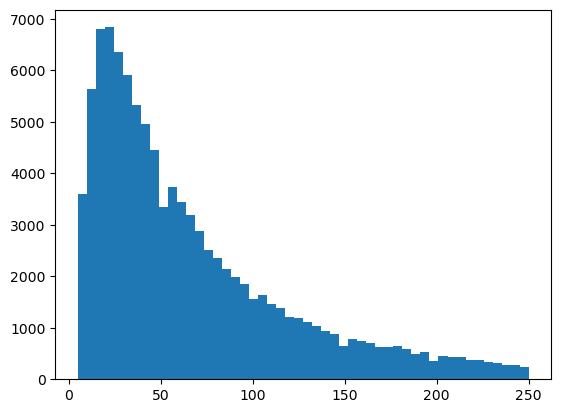

In [21]:
print(min(num_tracks))
print(max(num_tracks))
plt.hist(num_tracks, bins=50)

In [22]:
# do the most popular songs appear towards the top of playlists?

In [23]:
# if you know that a certain artist appears in someones playlist, how much more likley are they to have another song from that same artist?